In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [162]:
def normalize(X):
    return (X - X.mean(axis=1)) / X.std(axis=1)

In [130]:
df_raw = pd.read_csv("data_full 30.11 21-10 correct.csv", sep=',').drop("Unnamed: 0", axis=1)

In [131]:
df_raw

,active_finished_ratio,answer_time,first_sold_time,max_active_cost,max_finished_cost,mean_active_cost,mean_finished_cost,min_active_cost,min_finished_cost,n_active,n_finished,name,person_status,start_date,url
0,1.500000,Отвечает за несколько часов,736367.0,300000.0,17000.0,3.567273e+04,5.671429e+03,50.0,700.0,11,7,идрис,частное лицо,736269.0,https://www.avito.ru/user/9195337e39128000a45e...
1,0.648649,Отвечает за несколько часов,735879.0,9000.0,210000.0,8.380435e+02,6.710806e+03,25.0,9.0,23,36,ольга,частное лицо,734777.0,https://www.avito.ru/user/52926fb084606d3cde37...
2,3.937500,Отвечает в течение дня,736780.0,7500.0,7000.0,1.331452e+03,1.160000e+03,100.0,100.0,62,15,милана,частное лицо,736726.0,https://www.avito.ru/user/c755b70a27e284bc94c0...
3,0.120000,Отвечает за несколько часов,736700.0,35000.0,35000.0,8.700000e+03,2.624490e+03,1000.0,200.0,5,49,людмила,частное лицо,736695.0,https://www.avito.ru/user/aef0f368e1e801fc739c...
4,5.000000,Отвечает за несколько часов,735133.0,4500.0,16500.0,1.508483e+03,6.050000e+03,350.0,450.0,29,5,настя,частное лицо,734258.0,https://www.avito.ru/user/152e3a9a5b7ca1df387c...
5,1.555556,NaN,736301.0,2000.0,2300.0,1.046154e+03,1.347250e+03,750.0,350.0,13,8,анастасия,частное лицо,735599.0,https://www.avito.ru/user/cba77ac25ab81a3b5ebf...
6,0.950000,Отвечает около 30 минут,735535.0,160000.0,600000.0,4.398571e+03,4.773701e+03,0.0,0.0,455,479,оксана,компания,733163.0,https://www.avito.ru/user/107448555ec79a8db1bd...
7,2.000000,Отвечает в течение дня,736877.0,3000.0,5000.0,1.833333e+03,2.250000e+03,500.0,1000.0,9,4,иван палкин,частное лицо,736573.0,https://www.avito.ru/user/b5734818dff3626cd004...
8,12.666667,Отвечает за несколько часов,736950.0,640000.0,5500.0,9.324667e+03,1.620000e+03,30.0,200.0,75,5,ольга,частное лицо,735477.0,https://www.avito.ru/user/58b825115db296723c4d...
9,1.666667,Отвечает за несколько часов,736835.0,16300.0,2600.0,3.422222e+03,2.040000e+03,500.0,1400.0,9,5,татьяна,частное лицо,734869.0,https://www.avito.ru/user/8acdb97e06aa07a26bad...


In [132]:
df = df_raw.copy()

In [133]:
list(df_raw.person_status.unique())

['частное лицо', 'компания', 'магазин']

In [134]:
list(df_raw.answer_time.unique())

['Отвечает за несколько часов',
 'Отвечает в течение дня',
 nan,
 'Отвечает около 30 минут',
 'Редко отвечает на сообщения, рекомендуем звонить',
 'Отвечает около часа',
 'Редко отвечает на сообщения']

In [135]:
def min_cost_general(n_act, n_fin, min_act, min_fin):
    return np.minimum(min_fin.fillna(np.inf), min_act.fillna(np.inf))

def max_cost_general(n_act, n_fin, max_act, max_fin):
    return np.maximum(max_fin.fillna(-1), max_act.fillna(-1))

def mean_cost_general(n_act, n_fin, mean_act, mean_fin):
    return (mean_act.fillna(0) * n_act + mean_fin.fillna(0) * n_fin) / (n_act + n_fin)

In [136]:
anstime_mapping = {
    'Отвечает за несколько часов': 5,
    'Отвечает в течение дня': 24,
#     np.nan: np.nan,
    'Отвечает около 30 минут': 0.5,
    'Редко отвечает на сообщения, рекомендуем звонить': 24 * 7,
    'Отвечает около часа': 1,
    'Редко отвечает на сообщения': 24 * 7
}

In [137]:
status_mapping = {
    'частное лицо': 0,
    'компания': 1,
    'магазин': np.nan
}

In [138]:
df.replace({'answer_time': anstime_mapping, 'person_status': status_mapping}, inplace=True)

In [139]:
df.drop(["url", "name"], axis=1, inplace=True)

In [140]:
df_raw.columns

Index(['active_finished_ratio', 'answer_time', 'first_sold_time',
       'max_active_cost', 'max_finished_cost', 'mean_active_cost',
       'mean_finished_cost', 'min_active_cost', 'min_finished_cost',
       'n_active', 'n_finished', 'name', 'person_status', 'start_date', 'url'],
      dtype='object')

In [144]:
df["first_sold_interval"] = df["first_sold_time"] - df["start_date"]

In [147]:
df

,active_finished_ratio,answer_time,first_sold_time,max_active_cost,max_finished_cost,mean_active_cost,mean_finished_cost,min_active_cost,min_finished_cost,n_active,n_finished,person_status,start_date,first_sold_interval
0,1.500000,5.0,736367.0,300000.0,17000.0,3.567273e+04,5.671429e+03,50.0,700.0,11,7,0.0,736269.0,98.0
1,0.648649,5.0,735879.0,9000.0,210000.0,8.380435e+02,6.710806e+03,25.0,9.0,23,36,0.0,734777.0,1102.0
2,3.937500,24.0,736780.0,7500.0,7000.0,1.331452e+03,1.160000e+03,100.0,100.0,62,15,0.0,736726.0,54.0
3,0.120000,5.0,736700.0,35000.0,35000.0,8.700000e+03,2.624490e+03,1000.0,200.0,5,49,0.0,736695.0,5.0
4,5.000000,5.0,735133.0,4500.0,16500.0,1.508483e+03,6.050000e+03,350.0,450.0,29,5,0.0,734258.0,875.0
5,1.555556,NaN,736301.0,2000.0,2300.0,1.046154e+03,1.347250e+03,750.0,350.0,13,8,0.0,735599.0,702.0
6,0.950000,0.5,735535.0,160000.0,600000.0,4.398571e+03,4.773701e+03,0.0,0.0,455,479,1.0,733163.0,2372.0
7,2.000000,24.0,736877.0,3000.0,5000.0,1.833333e+03,2.250000e+03,500.0,1000.0,9,4,0.0,736573.0,304.0
8,12.666667,5.0,736950.0,640000.0,5500.0,9.324667e+03,1.620000e+03,30.0,200.0,75,5,0.0,735477.0,1473.0
9,1.666667,5.0,736835.0,16300.0,2600.0,3.422222e+03,2.040000e+03,500.0,1400.0,9,5,0.0,734869.0,1966.0


In [150]:
df.drop(["first_sold_time", "start_date"], axis=1, inplace=True)

In [151]:
df["min_general_cost"] = min_cost_general(df.n_active, df.n_finished, df.min_active_cost, df.min_finished_cost)
df["max_general_cost"] = max_cost_general(df.n_active, df.n_finished, df.max_active_cost, df.max_finished_cost)
df["mean_general_cost"] = mean_cost_general(df.n_active, df.n_finished, df.mean_active_cost, df.mean_finished_cost)

In [152]:
# df_raw[df_raw.n_active + df_raw.n_finished == 0]

In [153]:
# df_raw[df_raw.n_active + df_raw.n_finished == 0]["url"].values

In [154]:
df["min_general_cost"][df["min_general_cost"] == np.inf] = np.nan
df["max_general_cost"][df["max_general_cost"] < 0] = np.nan

/home/garx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/garx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [155]:
df.dropna(subset=["min_general_cost", "person_status", "first_sold_interval"], inplace=False).shape

(6972, 15)

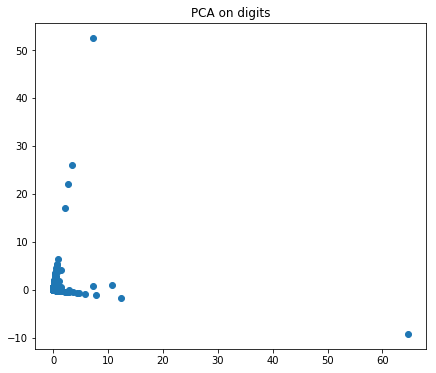

In [156]:
scaler = StandardScaler()
pca_scaler = PCA(n_components=2, random_state=140)
data_pca = scaler.fit_transform(pca_scaler.fit_transform(df.dropna().values))
plt.figure(figsize=(7, 6))
plt.title('PCA on digits')
plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.show()

In [157]:
df.columns

Index(['active_finished_ratio', 'answer_time', 'max_active_cost',
       'max_finished_cost', 'mean_active_cost', 'mean_finished_cost',
       'min_active_cost', 'min_finished_cost', 'n_active', 'n_finished',
       'person_status', 'first_sold_interval', 'min_general_cost',
       'max_general_cost', 'mean_general_cost'],
      dtype='object')

In [158]:
cols = ['person_status',
        'first_sold_interval',
        'answer_time',
        'n_active',
        'n_finished',
        'active_finished_ratio',
        'min_active_cost',
        'max_active_cost',
        'mean_active_cost',
        'min_finished_cost',
        'max_finished_cost',
        'mean_finished_cost',
        'min_general_cost',
        'max_general_cost',
        'mean_general_cost',
       ]
cols2 = ['person_status',
        'first_sold_interval',
        'answer_time',
        'n_active',
        'n_finished',
        'active_finished_ratio',
        'min_general_cost',
        'max_general_cost',
        'mean_general_cost',
       ]

In [172]:
df["person_status"].mean()

0.15582837000121552

In [ ]:
df_norm = df.copy()
cols_to_norm = ['person_status',
                'first_sold_interval',
                'answer_time',
                'n_active',
                'n_finished',
        'active_finished_ratio',
        'min_active_cost',
        'max_active_cost',
        'mean_active_cost',
        'min_finished_cost',
        'max_finished_cost',
        'mean_finished_cost',
        'min_general_cost',
        'max_general_cost',
        'mean_general_cost',
               ]
df_norm[cols_to_norm] = survey_data[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())

/home/garx/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/garx/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/garx/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/garx/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


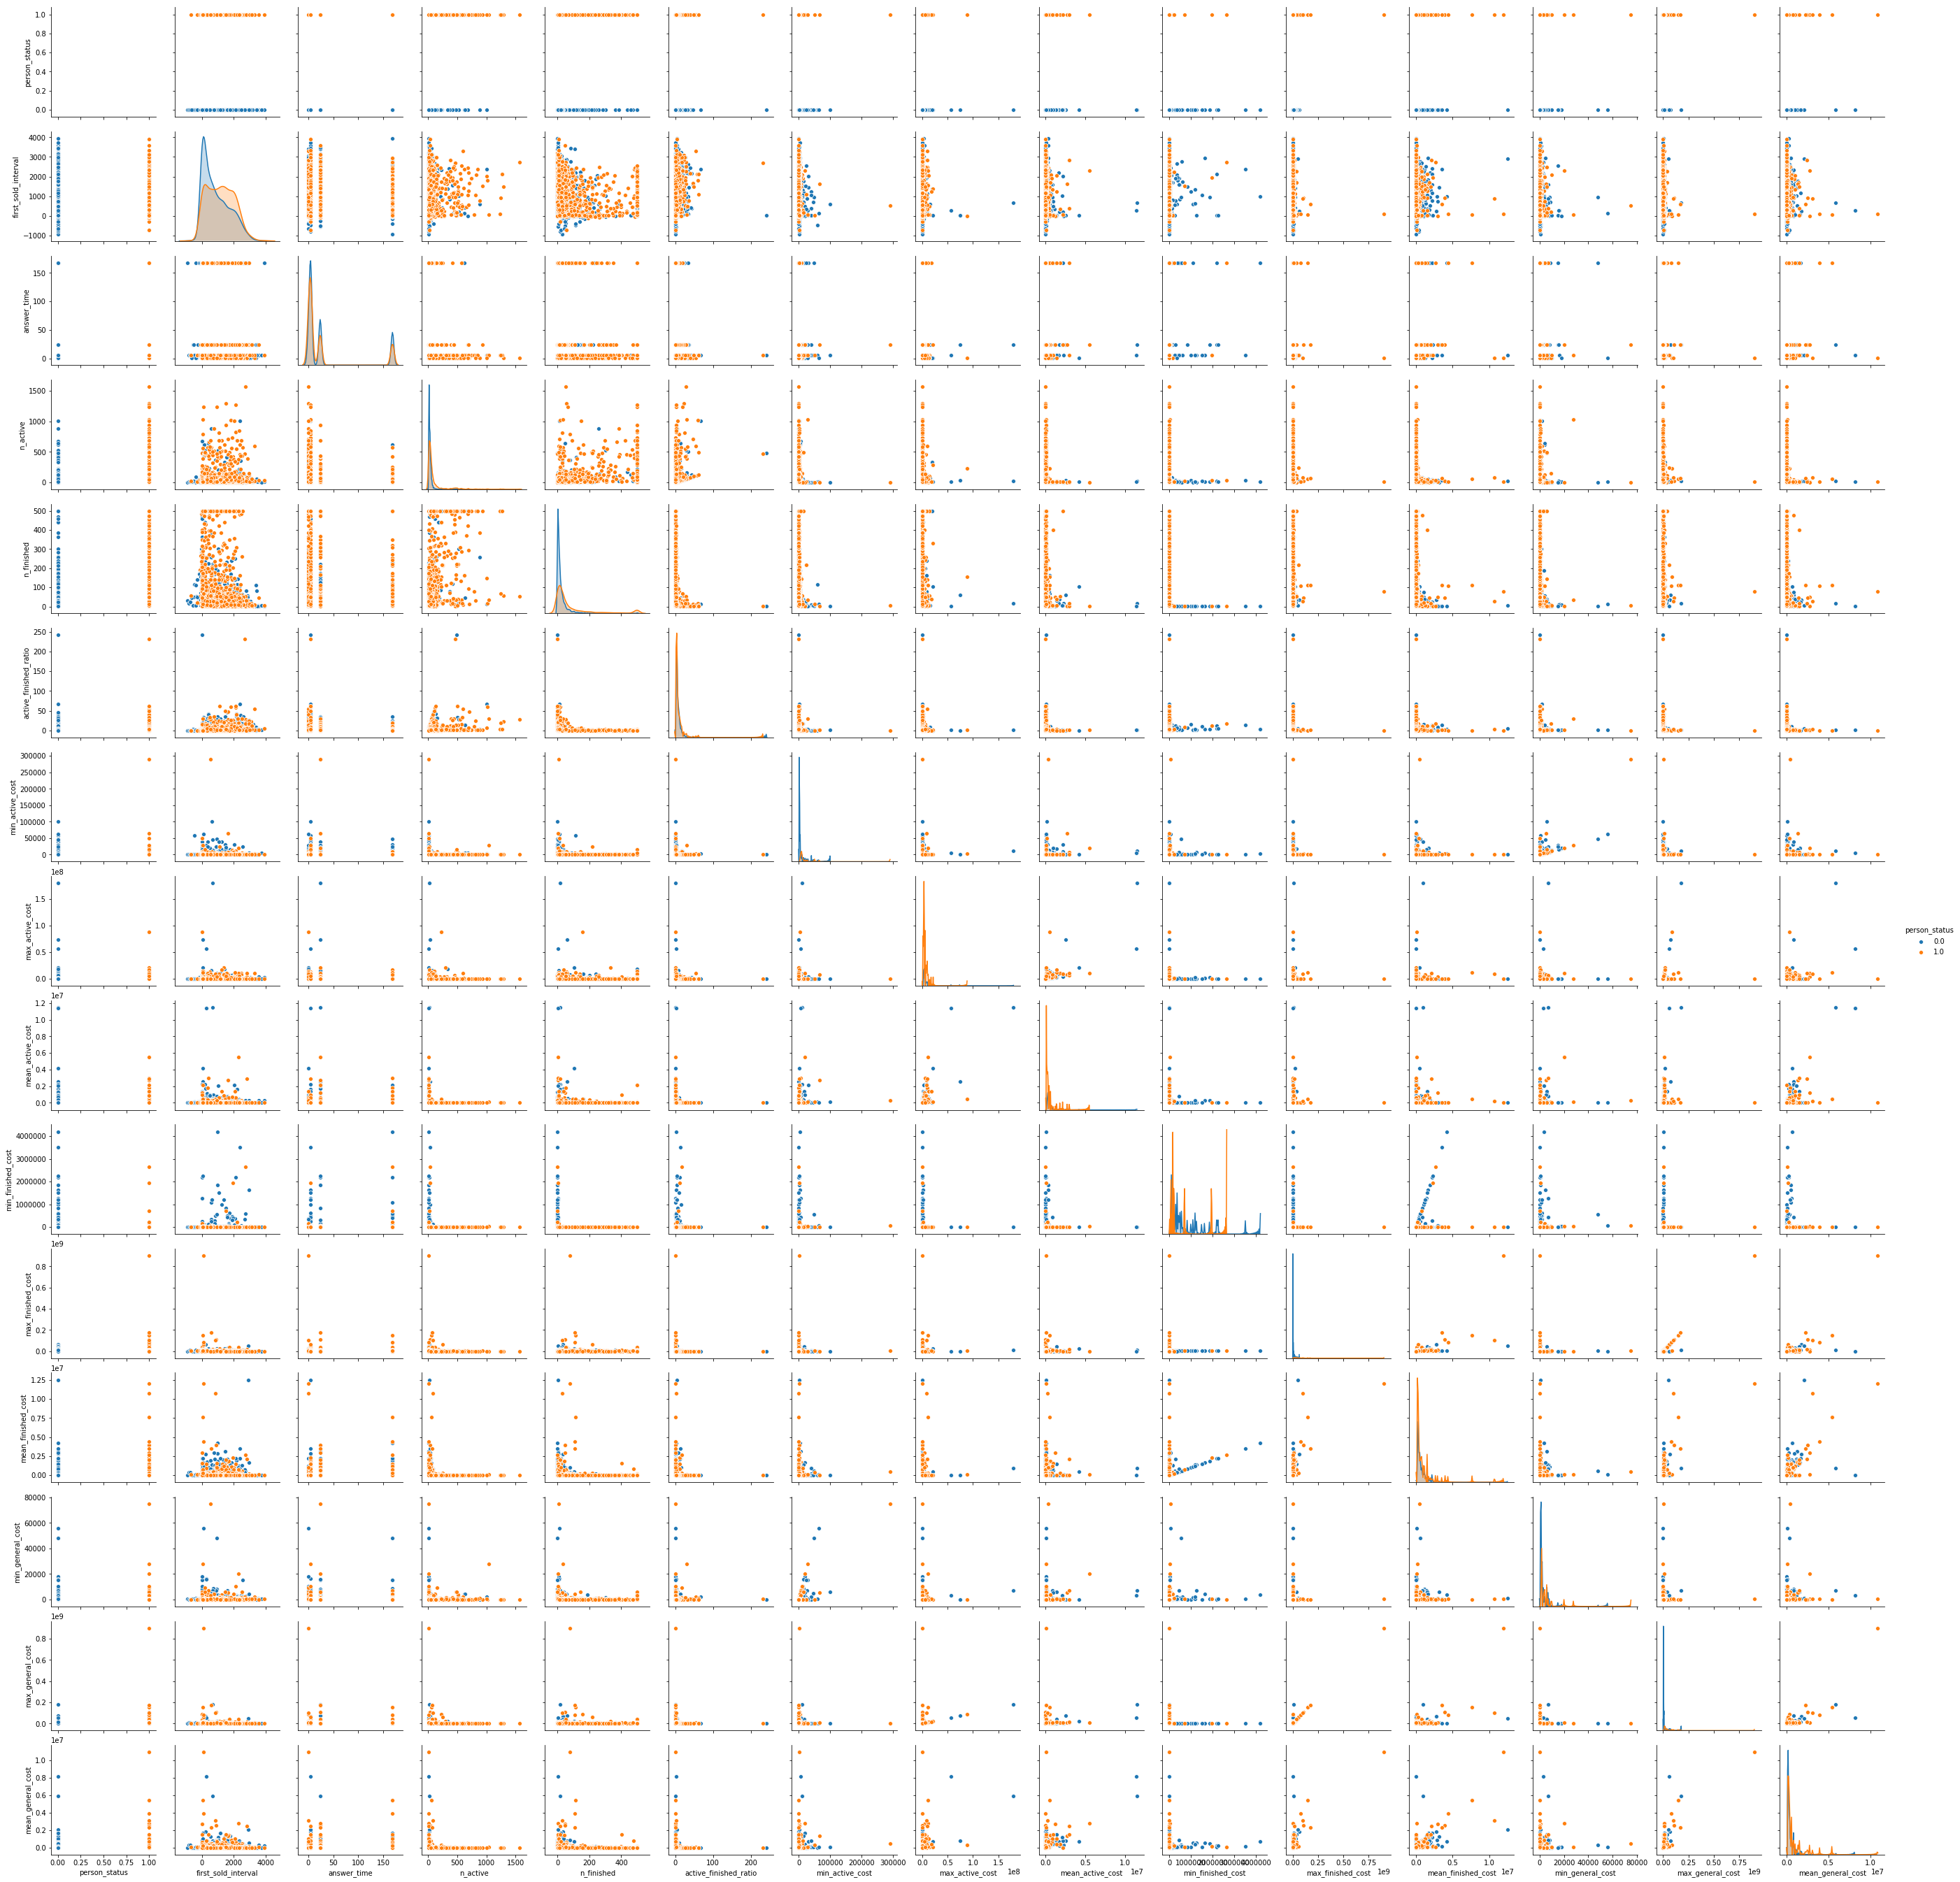

In [159]:
sns.pairplot(df[cols].dropna(), kind='scatter', hue='person_status')

/home/garx/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/garx/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/garx/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/garx/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


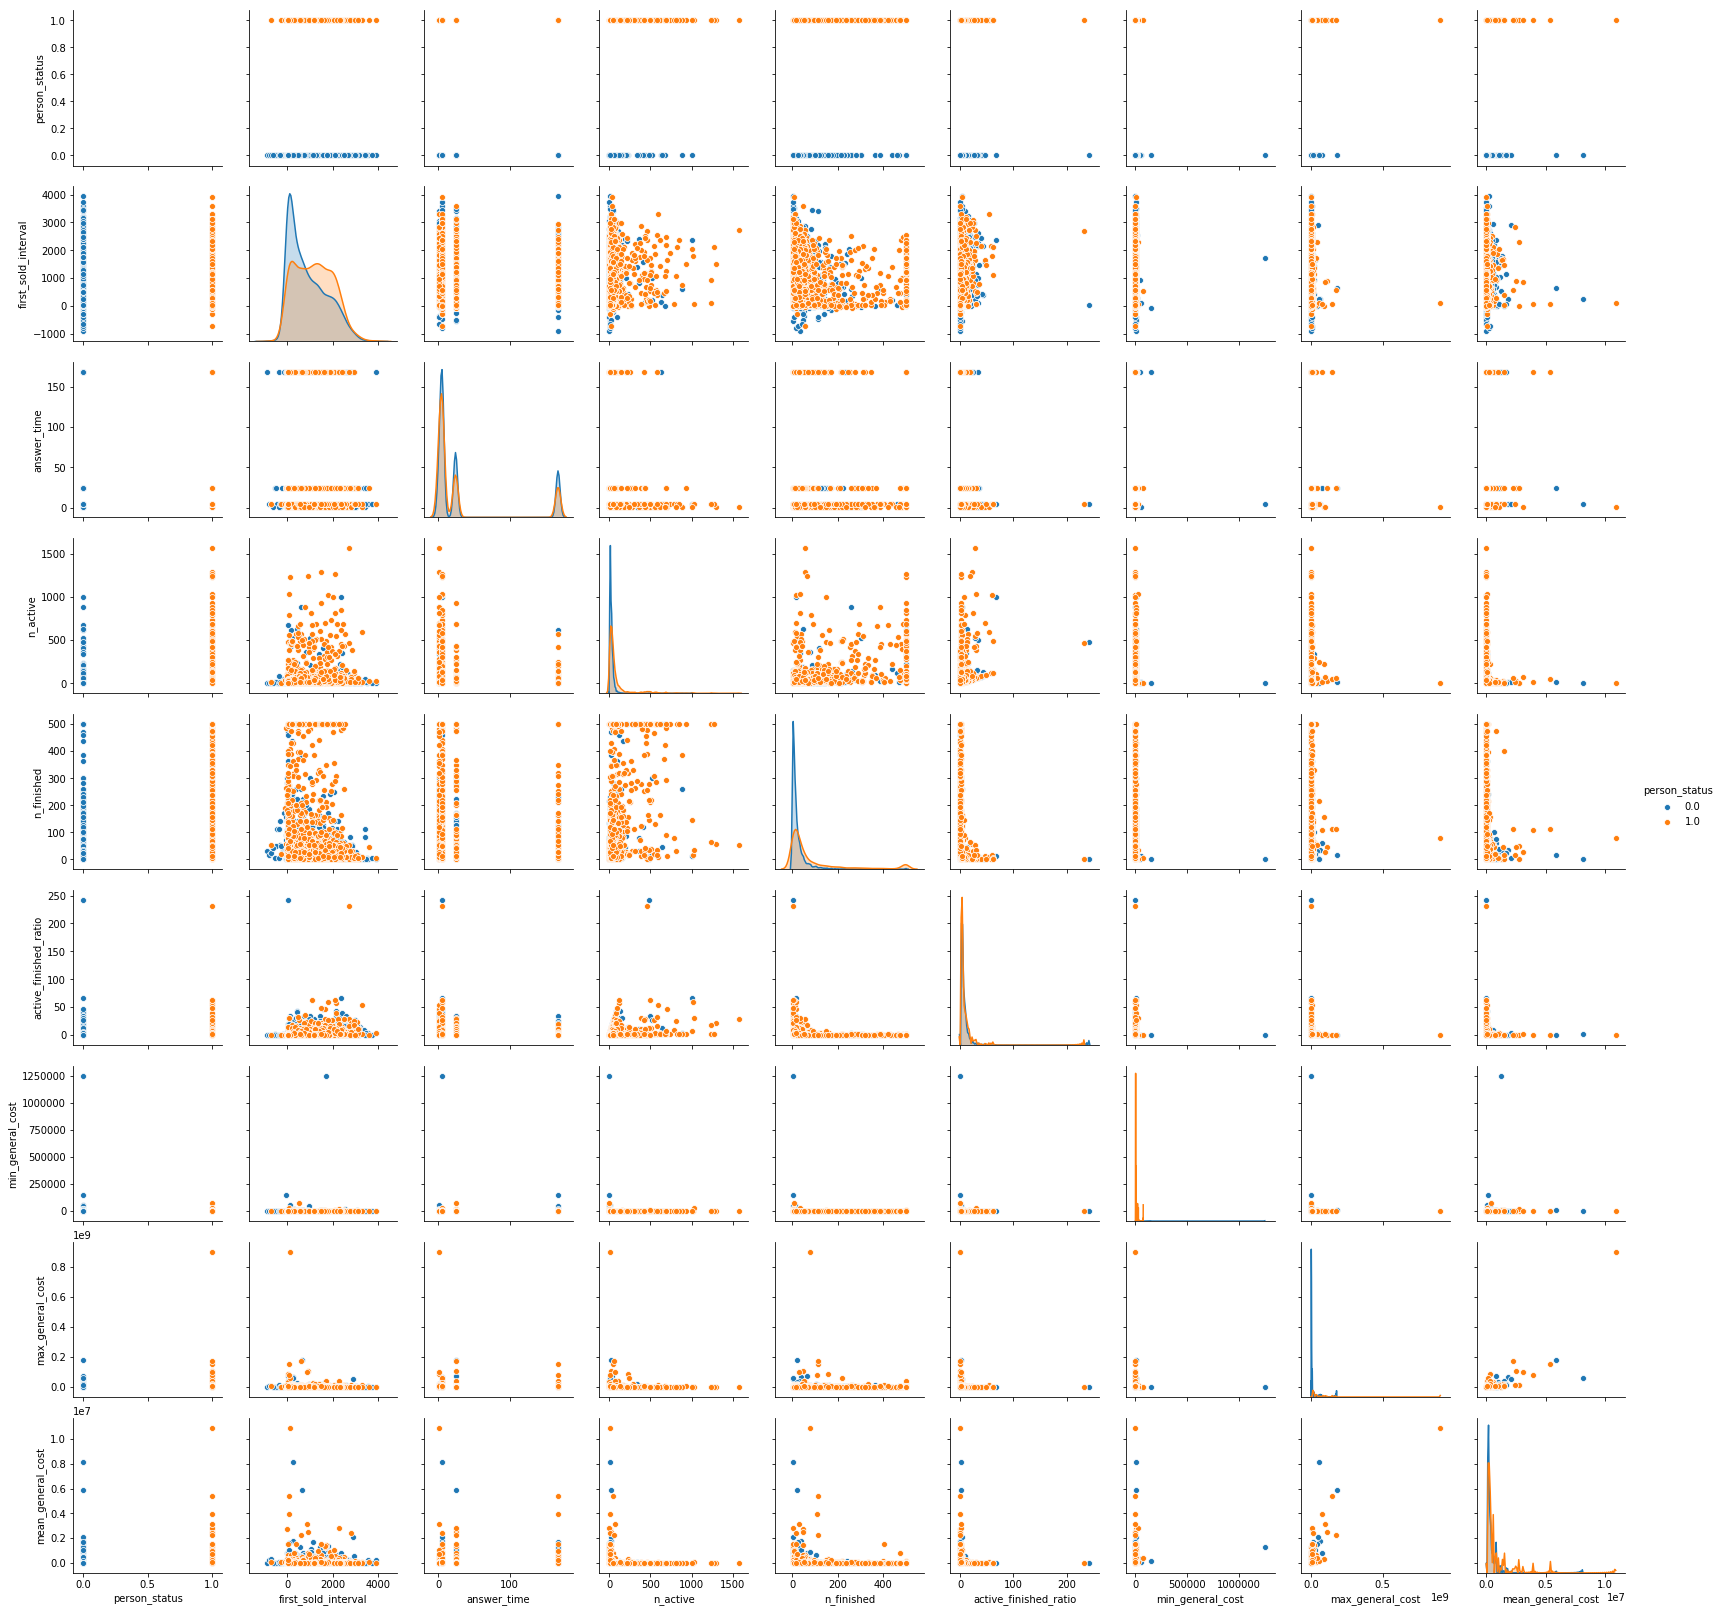

In [160]:
sns.pairplot(df[cols2].dropna(), kind='scatter', hue='person_status')

In [123]:
df.person_status.value_counts()

0.0    6945
1.0    1282
Name: person_status, dtype: int64